In [1]:
from utils import *

In [3]:
v = True

generate_auction_scandata(verbose=v)
generate_auction_activity(verbose=v)
generate_inventory(verbose=v)

Auction scandata loaded and cleaned. 27684 records, last updated 2020-04-13 21:35:12 by 396255466#1
Auction scandata full repository. 196233 records with 7 snapshots. Repository has  been updated this run
Auction actions full repository. 17040 records
Inventory formatted. 451 records, 591 total money across chars
Inventory full repository. 2218 records with 5 snapshots. Repository has  been updated this run


In [10]:
def get_item_prices():
    """
    Generate item prices based on all past auction activity and scans
    """

    auction_activity = pd.read_parquet('full/auction_activity.parquet')
    auction_activity = auction_activity[['item', 'timestamp', 'price_per', 'auction_type']]

    auction_scandata = pd.read_parquet('full/auction_scandata.parquet')
    auction_scandata = auction_scandata[auction_scandata['price_per']!=0]
    auction_scandata['price_per'] = auction_scandata['price_per'].astype(int)
    auction_scandata['auction_type'] = 'market'
    auction_scandata = auction_scandata.groupby(['item', 'timestamp'])['price_per'].min().reset_index()

    df_auction_prices = auction_scandata.append(auction_activity)

    items = df_auction_prices['item'].unique()
    df_auction_prices = df_auction_prices.set_index(['item', 'timestamp']).sort_index()
    item_prices = {item: df_auction_prices.loc[item, 'price_per'].ewm(alpha=0.2).mean().iloc[-1] for item in items}
    return item_prices

In [11]:
item_prices = get_item_prices()

In [8]:
inventory_full = pd.read_parquet('full/inventory.parquet')
inventory_full['price_per'] = inventory_full['item'].apply(lambda x: item_prices.get(x, 0))
inventory_full['total_value'] = inventory_full['count'] * inventory_full['price_per']
inventory_value = inventory_full.groupby(['timestamp', 'character']).sum()['total_value'].unstack()

monies_full = pd.read_parquet('full/monies.parquet')
monies_full = monies_full.reset_index().set_index(['timestamp', 'index'])['monies'].unstack()

inv_mule = inventory_value['Amazona']
inv_rest = inventory_value.sum(axis=1) - inv_mule
monies_mule = monies_full['Amazona - Grobbulus']
monies_mule.name = 'Monies - Amazona'
monies_rest = monies_full.sum(axis=1) - monies_mule

holdings = pd.DataFrame(monies_mule)
holdings['Monies - Rest'] = monies_rest
holdings['Inv - Amazona'] = inv_mule.values
holdings['Inv - Rest'] = inv_rest.values
holdings = (holdings/10000).astype(int)

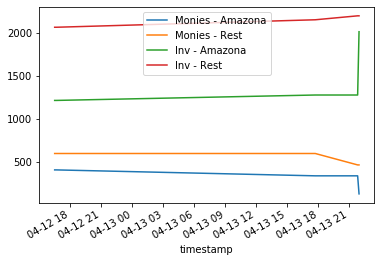

In [64]:
holdings.plot()

In [79]:
generate_market_average_prices()
generate_item_sell_prices()
prices = pd.read_parquet('intermediate/sell_prices.parquet')
prices['min_list_price']/10000

In [85]:
prices = pd.read_parquet('intermediate/sell_prices.parquet')

In [86]:
prices[['gross_profit', 'auction_success']].dropna()

,gross_profit,auction_success
item,,
Arcane Elixir,450.391077,0.903846
Elixir of Fortitude,2774.435328,0.663755
Elixir of Giants,2543.878149,0.854772
Elixir of Greater Agility,-88.857261,0.838174
Elixir of Greater Intellect,1582.003412,0.705882
Elixir of Shadow Power,1518.145185,0.851852
Elixir of Superior Defense,10124.354000,0.479167
Elixir of the Mongoose,2037.696298,0.938017
Fire Protection Potion,2620.741585,0.751037


In [87]:
prices['ingredient_value'] = prices['gross_profit'] * prices['auction_success']

In [88]:
user_items = load_items()

In [89]:
ingredient_df = pd.DataFrame()
for item, details in user_items.items():
    if details.get('made_from'):
        for ingredient, count in details.get('made_from').items():
            ingredient_df.loc[item, ingredient] = count
        
# xs = ingredient_df.drop(['Crystal Vial', 'Leaded Vial', 'Empty Vial'], axis=1).fillna(0).astype(int)
# ys = ingredient_raw['ingredient_value']

In [90]:
ingredient_raw

NameError: name 'ingredient_raw' is not defined

In [91]:
def update_beta(pred_beta, y, x, learning_rate=0.02):
    actual_value = y * (x / x.sum())
    actual_value = actual_value[actual_value>0]

    new_beta = pred_beta.copy()
    new_beta.update(actual_value)

    # Introduce some truthiness to the betas
    pred_beta += ((new_beta - pred_beta) * learning_rate)
    return pred_beta

In [92]:
import numpy as np

In [93]:
random_start = ((np.random.rand(len(xs.columns)) - 0.5) + 1) * ys.mean()

NameError: name 'xs' is not defined

In [94]:
pred_beta = pd.Series(random_start, index=xs.columns)

NameError: name 'random_start' is not defined

In [95]:
all_betas = pd.DataFrame(columns=pred_beta.index)

for i in range(800):
    for item, y in ys.sample(10).items():
        x = xs.loc[item]
        pred_beta = update_beta(pred_beta, y, x, learning_rate=0.005)
        
        if verbose:
            beta_proportion = ((pred_beta / pred_beta.sum()))
            all_betas.loc[i] = beta_proportion
if verbose:
    all_betas.plot(legend=False)
            
beta_proportion = ((pred_beta / pred_beta.sum()))            
beta_proportion.sort_values()         

NameError: name 'pred_beta' is not defined

In [96]:
pred_beta

NameError: name 'pred_beta' is not defined

In [97]:
# Need a POPULARITY metric, something that signifies how many of the last x auctions have been item

In [98]:
def analyse_stocktake_value(excluded_characters=[]):
    df = pd.read_parquet('intermediate/inventory.parquet')

    item_count = df.groupby('item')['count'].sum()
    items = load_items()
    # Adjust for self demand
    for item, detail in items.items():
        if 'self_demand' in detail:
            for character, count in detail['self_demand'].items():
                if character not in excluded_characters:
                    if item in item_count.index:
                        item_count.loc[item] -= count

    ####

    # Get prices from below
    prices.name = 'price'
    stocktake = pd.DataFrame(item_count).join(prices)
    stocktake['est'] = stocktake['count'] * stocktake['price']
    print(int(stocktake['est'].sum() / 10000))                
    
    
analyse_stocktake_value(excluded_characters=['Amazoni'])    

KeyError: 'price'